In [2]:
import pandas as pd
import numpy as np
from statsmodels.tools import add_constant
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

In [6]:
# 1. 데이터 불러오기
df = pd.read_csv('regression.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.drop(0, axis=0, inplace=True)
df.head()

,date,HK_exports_to_Korea_logdiff,seizure_diff
1,2001-03-01,0.023309,-1795.0
2,2001-04-01,-0.014729,-399.0
3,2001-05-01,-0.017692,38509.0
4,2001-06-01,-0.151941,-39172.0
5,2001-07-01,0.092546,3474.0


In [141]:
# 분석 코드
# sliding window size: 24개월
# max lag: 12개월

def ols(df, date_col_name='date', x_col_name='HK_exports_to_Korea_logdiff', y_col_name='seizure_diff', window_size=24, max_lag=12) :
    
    results = []
    
    for start in tqdm(range(len(df) - window_size + 1)) :
        end = start + window_size
        window_df = df.iloc[start: end].copy()
    
        best_r2 = -np.inf
        best_lag = None
        best_beta = None
        best_pval = None
    
        # lag별 회귀 성능 비교
        for lag in range(0, max_lag + 1) :
            X = window_df[x_col_name].shift(lag)
            y = window_df[y_col_name]
    
            valid_idx = X.notna() & y.notna()
            X_valid = X[valid_idx]
            y_valid = y[valid_idx]
    
            if len(X_valid) < 10 :
                continue
    
            X_valid = sm.add_constant(X_valid)
            
            # OLS + Newey–West HAC
            model = sm.OLS(y_valid, X_valid).fit(
                cov_type='HAC', 
                cov_kwds={'maxlags': lag if lag > 0 else 1}  # 최소 1
            )
    
            if model.rsquared > best_r2 :
                best_r2 = model.rsquared
                best_lag = lag
                best_beta = model.params.iloc[1]
                best_pval = model.pvalues.iloc[1]
    
        # 필터링 된 위험도 계산
        if (best_beta is not None) and (best_beta > 0) and (best_pval < 0.05) :
            risk_score = best_beta
        else:
            risk_score = 0
    
        # 윈도우 중앙 시점 기준 기록
        mid_date = window_df[date_col_name].iloc[window_size // 2]
        results.append({
            'date': mid_date,
            'best_lag': best_lag,
            'beta': best_beta,
            'pval': best_pval,
            'r2': best_r2,
            'risk_score': risk_score
        })

    # 결과 도출
    result_df = pd.DataFrame(results)
    # risk score에 로그 적용(극단값 방지)
    #result_df.loc[result_df['risk_score']!=0, 'risk_score'] = np.log(result_df.loc[result_df['risk_score']!=0]['risk_score'])

    #시각화
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result_df['date'], y=result_df['risk_score'], mode='lines'))
    fig.show()
    
    return result_df

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:04<00:00, 66.37it/s]


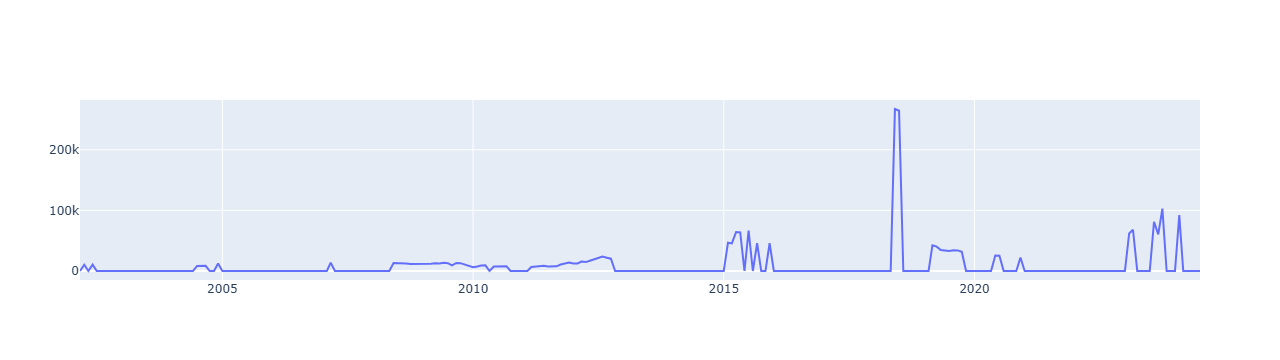

In [142]:
result_non_log = ols(df, date_col_name='date', x_col_name='HK_exports_to_Korea_logdiff', y_col_name='seizure_diff', window_size=24, max_lag=12)

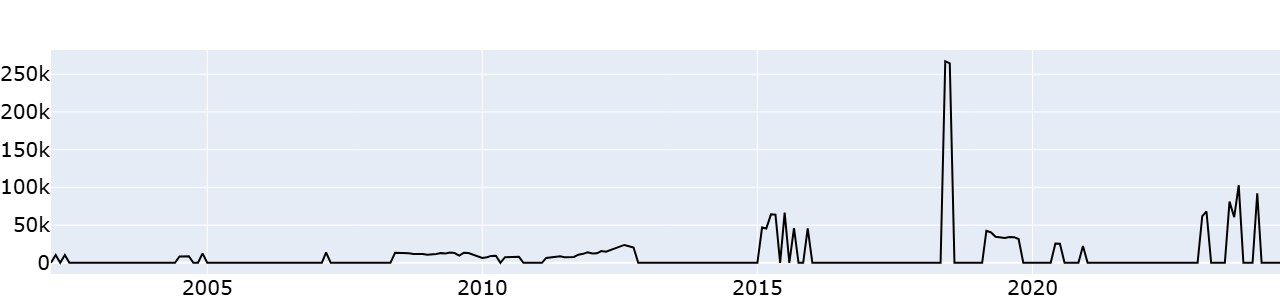

In [146]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result_non_log['date'], y=result_non_log['risk_score'], mode='lines', line={'color': 'black'}))
fig.update_layout(width=1200, height=300, margin_t=50, margin_b=10, margin_l=0, margin_r=0, font={'size': 20, 'color': 'black'})
fig.show()

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:03<00:00, 68.14it/s]


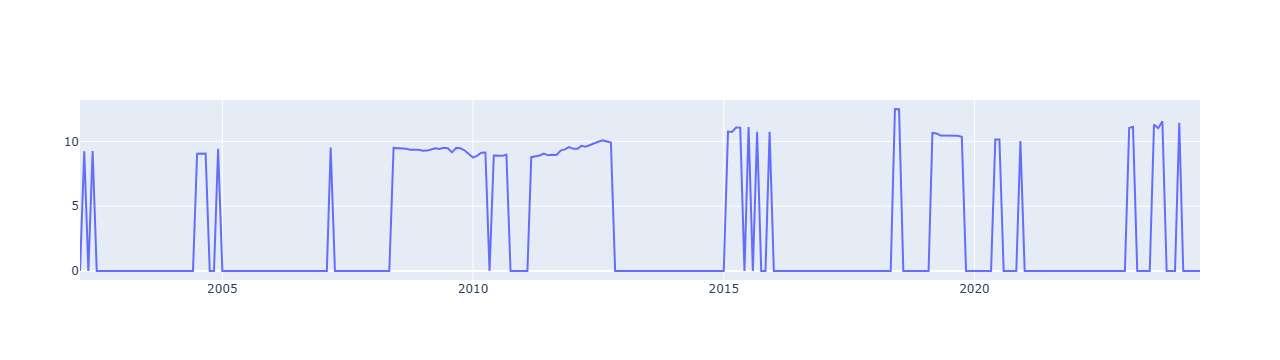

In [65]:
# 결과값에 로그 적용
result = ols(df, date_col_name='date', x_col_name='HK_exports_to_Korea_logdiff', y_col_name='seizure_diff', window_size=24, max_lag=12)

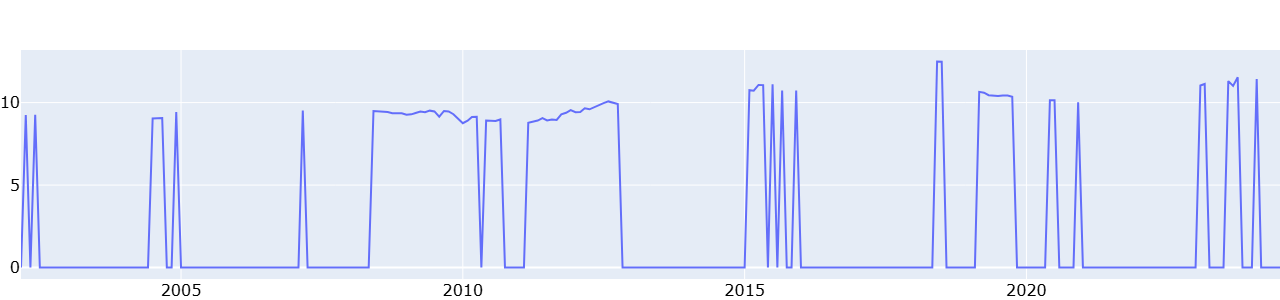

In [82]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result['date'], y=result['risk_score'], mode='lines'))
fig.update_layout(width=1200, height=300, margin_t=50, margin_b=10, margin_l=0, margin_r=0, font={'size': 16, 'color': "black"})
fig.show()

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:04<00:00, 67.18it/s]


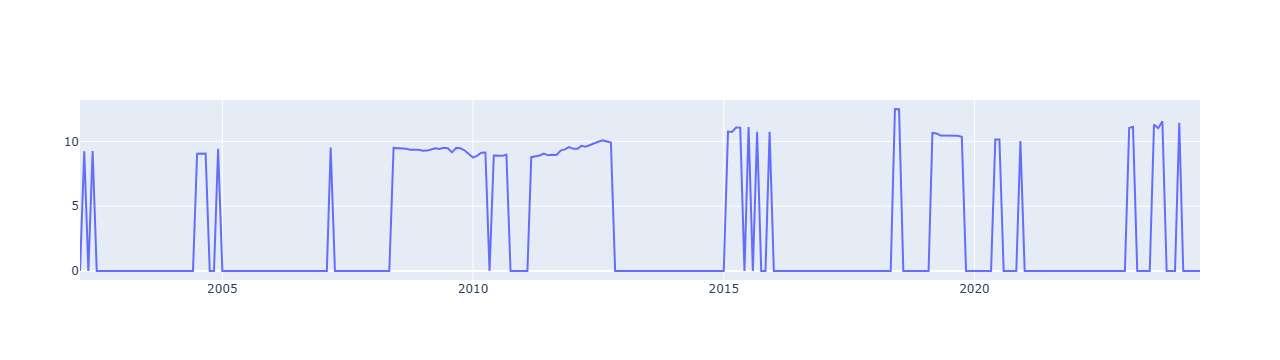

In [126]:
result = ols(df, date_col_name='date', x_col_name='HK_exports_to_Korea_logdiff', y_col_name='seizure_diff', window_size=24, max_lag=12)

In [134]:
result[['date', 'best_lag', 'risk_score']].loc[result['risk_score'] != 0]

,date,best_lag,risk_score
1,2002-04-01,9,9.242571
3,2002-06-01,9,9.256692
28,2004-07-01,1,9.040222
29,2004-08-01,1,9.047263
30,2004-09-01,1,9.065924
...,...,...,...
252,2023-03-01,11,11.127518
257,2023-08-01,11,11.303789
258,2023-09-01,11,11.011251
259,2023-10-01,7,11.542556


In [137]:
result[['date', 'best_lag', 'risk_score']].loc[result['risk_score'] != 0].to_csv('result.csv')

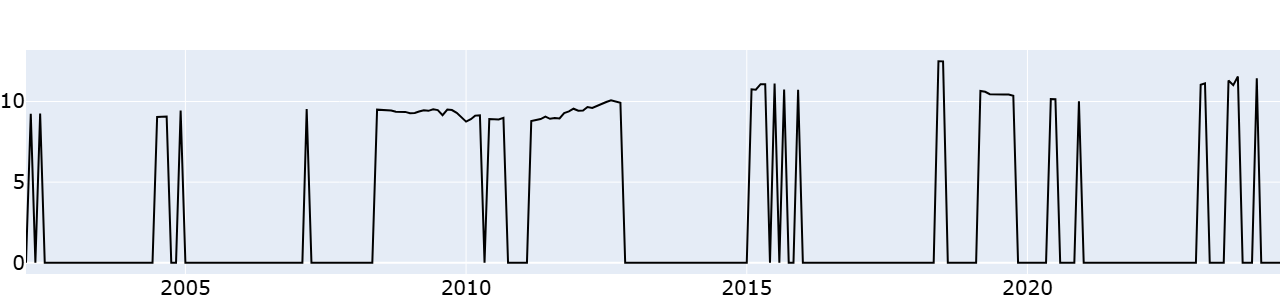

In [159]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result['date'], y=result['risk_score'], mode='lines', line={'color': 'black'}))
fig.update_layout(width=1200, height=300, margin_t=50, margin_b=10, margin_l=0, margin_r=0, font={'size': 20, 'color': "black"})
fig.show()

In [140]:
result

,date,best_lag,beta,pval,r2,risk_score
0,2002-03-01,12,-17727.024855,2.202713e-02,0.212285,0.000000
1,2002-04-01,9,10327.557484,1.239493e-02,0.175434,9.242571
2,2002-05-01,8,-11908.812365,1.951551e-03,0.260809,0.000000
3,2002-06-01,9,10474.425487,1.325388e-03,0.276054,9.256692
4,2002-07-01,12,-38955.512683,9.435212e-03,0.135691,0.000000
...,...,...,...,...,...,...
264,2024-03-01,7,-76221.021568,9.586288e-02,0.181063,0.000000
265,2024-04-01,7,-78383.597728,5.183315e-02,0.207668,0.000000
266,2024-05-01,7,-87796.882933,5.326124e-05,0.417835,0.000000
267,2024-06-01,7,-98826.457359,1.317927e-08,0.429806,0.000000
